Load modules/packages.

In [1]:
import pygam
import pandas
import numpy
import numpy.random
import seaborn
import matplotlib.pyplot 
import vtreat
import vtreat.util
import wvpy.util

Generate example data.

In [2]:
d = pandas.DataFrame({'x':[0.1*i for i in range(500)]})
d['y'] = numpy.sin(d['x']) + 0.1*numpy.random.normal(size=d.shape[0])
d['xc'] = ['level_' + str(5*numpy.round(yi/5, 1)) for yi in d['y']]
d['yc']= d['y']>0.5
d.head()

,x,y,xc,yc
0,0.0,-0.005373,level_-0.0,False
1,0.1,0.038527,level_0.0,False
2,0.2,0.266407,level_0.5,False
3,0.3,0.210790,level_0.0,False
4,0.4,0.484837,level_0.5,False


In [3]:
numpy.mean(d['yc']==True)

0.336

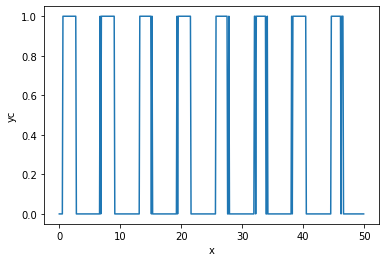

In [4]:
seaborn.lineplot(x='x', y='yc', data=d)

Build a classification model.

In [5]:
transform = vtreat.BinomialOutcomeTreatment(
    outcome_name='yc', 
    outcome_target=True,
    cols_to_copy=['y'])

In [6]:
d_prepared = transform.fit_transform(d, d['yc'])
d_prepared.head()

,y,yc,x,xc_logit_code,xc_prevalence_code,xc_lev_level_1.0,xc_lev_level_-1.0,xc_lev_level_0.5,xc_lev_level_-0.5
0,-0.005373,False,0.0,-5.824140,0.090,0,0,0,0
1,0.038527,False,0.1,-5.736512,0.076,0,0,0,0
2,0.266407,False,0.2,0.557611,0.190,0,0,1,0
3,0.210790,False,0.3,-5.811742,0.076,0,0,0,0
4,0.484837,False,0.4,0.503520,0.190,0,0,1,0


In [7]:
transform.score_frame_

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
0,x,x,clean_copy,False,True,-0.091528,4.077662e-02,1.0,True
1,xc_logit_code,xc,logit_code,True,True,0.851367,1.215835e-141,1.0,True
2,xc_prevalence_code,xc,prevalence_code,False,True,0.378105,1.937805e-18,1.0,True
3,xc_lev_level_1.0,xc,indicator_code,False,True,0.759623,4.204111e-95,4.0,True
4,xc_lev_level_-1.0,xc,indicator_code,False,True,-0.382189,7.765810e-19,4.0,True
5,xc_lev_level_0.5,xc,indicator_code,False,True,0.233754,1.241727e-07,4.0,True
6,xc_lev_level_-0.5,xc,indicator_code,False,True,-0.340040,5.338110e-15,4.0,True


Look at `xc_logit_code`.

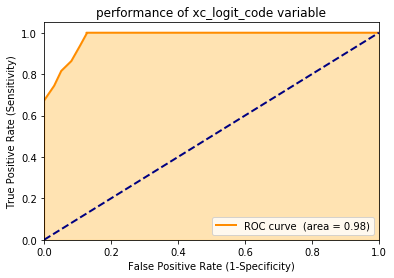

0.9784764056224899

In [8]:
wvpy.util.plot_roc(prediction=d_prepared['xc_logit_code'], 
                   istrue=d_prepared['yc'],
                   title = 'performance of xc_logit_code variable')

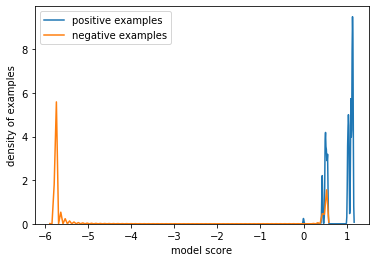

In [9]:
wvpy.util.dual_density_plot(probs=d_prepared['xc_logit_code'], 
                            istrue=d_prepared['yc'])

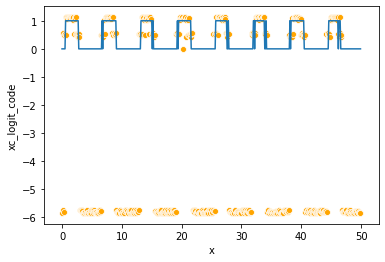

In [10]:
seaborn.lineplot(x='x', y='yc', data=d_prepared)
seaborn.scatterplot(x='x', y='xc_logit_code', data=d_prepared, 
                    color='orange')

Look at `xc_prevalence_code`.

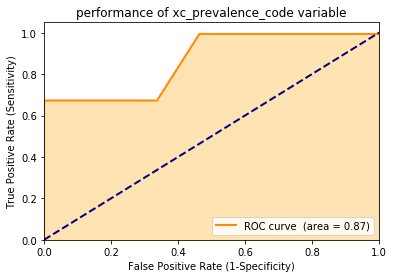

0.8652825588066553

In [11]:
wvpy.util.plot_roc(prediction=d_prepared['xc_prevalence_code'], 
                   istrue=d_prepared['yc'],
                   title = 'performance of xc_prevalence_code variable')

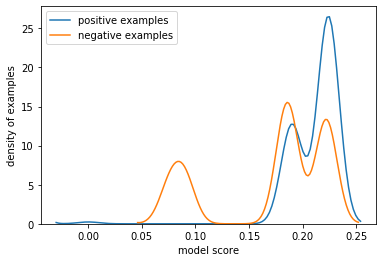

In [12]:
wvpy.util.dual_density_plot(probs=d_prepared['xc_prevalence_code'], 
                            istrue=d_prepared['yc'])

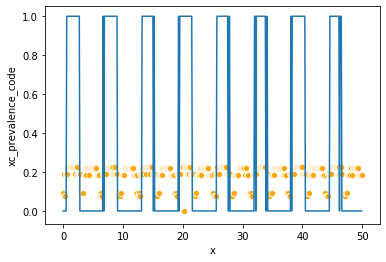

In [13]:
seaborn.lineplot(x='x', y='yc', data=d_prepared)
seaborn.scatterplot(x='x', y='xc_prevalence_code', data=d_prepared, 
                    color='orange')